# EnKF Experiments - GCS benchmark

This notebook consists of experiments undertaken for the benchmarking section of enkf results chapter 3.
This chapter focuses on the application of the Ensemble Kalman Filter to scenarios in which we do not know each agent's target destination prior to the beginning of the simulation.
In such scenarios, we need to use the Ensemble Kalman Filter to update estimates of both the locational state of each agent in the model and the target destination parameter for each agent.

Up to this point, the filter has been used to update estimates of only the location of each of the agents - a problem that is not entirely dissimilar to those to which the Ensemble Kalman Filter is typically applied.
In this case, however, the addition of estimating an agent's target destination presents an additional challenge.

Choosing a target destination for an agent involves identifying the gate to which the agent should be heading which can be considered a categorical problem.
Having identified a gate, we can then allocation a target destination in 2-dimensional real space as a location to which the agent will direct itself.

## Imports

In [1]:
# Imports
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import sys

In [2]:
sys.path.append('../../../../stationsim/')
from ensemble_kalman_filter import EnsembleKalmanFilter, AgentIncluder, GateEstimator, ExitRandomisation
from stationsim_gcs_model import Model

In [3]:
sys.path.append('../')
from experiment_utils import Modeller, Processor, Visualiser

In [4]:
%matplotlib inline
np.random.seed(42)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

In [6]:
def process_benchmark(model_path, vis=True):
    with open(model_path, 'rb') as f:
        baseline_filter = pickle.load(f)

    baseline_results = pd.DataFrame(baseline_filter.forecast_error)
    
    pop_size = baseline_filter.base_model.pop_total
    ensemble_size = baseline_filter.vanilla_ensemble_size
    randomisation = baseline_filter.exit_randomisation.name
    
    plt.figure()
    sns.lineplot(x='time', y='forecast', data=baseline_results)
    plt.xlabel('Time')
    plt.ylabel('Mean distance error per agent')
    plt.savefig(fig_dir + f'baseline_errors_p{pop_size}_e{ensemble_size}_{randomisation}.pdf')
    if vis:
        plt.show()
    
    bm = baseline_filter.base_model
    vms = baseline_filter.vanilla_models
    
    out_gates_truth = [agent.gate_out for agent in bm.agents]

    p = list()

    for m in vms:
        x = [out_gates_truth[i]==agent.gate_out for i, agent in enumerate(m.agents)]
        p.append(sum(x) / len(x))       
        
    s = f'benchmark_gates_correct_p{pop_size}_e{ensemble_size}_{randomisation}.pdf'
    plt.figure()
    plt.hist(p)
    plt.xlabel('Probabilty of picking the correct gate, p')
    plt.ylabel('Frequency')
    plt.savefig(fig_dir + s)
    if vis:
        plt.show()

In [16]:
def process_filter_benchmark(model_path, vis=True):
    with open(model_path, 'rb') as f:
        baseline_filter = pickle.load(f)

    baseline_results = pd.DataFrame(baseline_filter.metrics)
    forecast_results = pd.DataFrame(baseline_filter.forecast_error)
    
    pop_size = baseline_filter.base_model.pop_total
    ensemble_size = baseline_filter.ensemble_size
    randomisation = baseline_filter.exit_randomisation.name
    
    plt.figure()
    sns.lineplot(x='time', y='analysis', data=baseline_results, label='analysis')
    sns.lineplot(x='time', y='forecast', data=baseline_results, label='forecast')
    plt.xlabel('Time')
    plt.ylabel('Mean distance error per agent')
    plt.legend()
    plt.savefig(fig_dir + f'filter_baseline_errors_p{pop_size}_e{ensemble_size}_{randomisation}.pdf')
    if vis:
        plt.show()
    
    plt.figure()
    sns.lineplot(x='time', y='forecast', data=forecast_results, label='all')
    sns.lineplot(x='time', y='forecast', data=baseline_results, label='assimilation_steps')
    plt.xlabel('Time')
    plt.ylabel('Mean distance error per agent')
    plt.legend()
    plt.savefig(fig_dir + f'filter_baseline_forecast_errors_{pop_size}_{ensemble_size}_{randomisation}.pdf')
    if vis:
        plt.show()
    
    r_all = baseline_filter.results
    l = len(r_all)
    r = r_all[round(l/2)]
    results = list()
    
    obs = r['observation']
    obs_xs, obs_ys = baseline_filter.separate_coords(obs)

    for i in range(len(obs_xs)):
        obs_x = {'label': 'observation',
                 'value_type': 'x',
                 'agent_id': i,
                 'value': obs_xs[i]}
        obs_y = {'label': 'observation',
                 'value_type': 'y',
                 'agent_id': i,
                 'value': obs_ys[i]}
        results.extend([obs_x, obs_y])
    
    for i in range(ensemble_size):
        prior_label = f'prior_{i}'
        prior = r[prior_label]
        prior_xs, prior_ys = baseline_filter.separate_coords(prior)

        posterior_label = f'posterior_{i}'
        posterior = r[posterior_label]
        posterior_xs, posterior_ys = baseline_filter.separate_coords(posterior)

        assert len(prior_xs) == len(prior_ys)
        assert len(prior_xs) == len(posterior_xs)
        assert len(posterior_xs) == len(posterior_ys)

        population_size = len(prior_xs)

        for j in range(population_size):

            prior_x = {'label': 'prior',
                       'value_type': 'x',
                       'ensemble_id': i,
                       'agent_id': j,
                       'value': prior_xs[j]}
            prior_y = {'label': 'prior',
                       'value_type': 'y',
                       'ensemble_id': i,
                       'agent_id': j,
                       'value': prior_ys[j]}
            posterior_x = {'label': 'posterior',
                           'value_type': 'x',
                           'ensemble_id': i,
                           'agent_id': j,
                           'value': posterior_xs[j]}
            posterior_y = {'label': 'posterior',
                           'value_type': 'y',
                           'ensemble_id': i,
                           'agent_id': j,
                           'value': posterior_ys[j]}
            results.extend([prior_x, prior_y, posterior_x, posterior_y])
    
    results = pd.DataFrame(results)

    for i in range(pop_size):
        print(f'Agent {i}')
        prior_x_i = results.loc[(results['label']=='prior') & (results['value_type']=='x') & (results['agent_id']==i), :]
        posterior_x_i = results.loc[(results['label']=='posterior') & (results['value_type']=='x') & (results['agent_id']==i), :]
        prior_y_i = results.loc[(results['label']=='prior') & (results['value_type']=='y') & (results['agent_id']==i), :]
        posterior_y_i = results.loc[(results['label']=='posterior') & (results['value_type']=='y') & (results['agent_id']==i), :]

        obs_x_i = results.loc[(results['label']=='observation') & (results['value_type']=='x') & (results['agent_id']==i), :]
        obs_y_i = results.loc[(results['label']=='observation') & (results['value_type']=='y') & (results['agent_id']==i), :]

        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

        ax1.hist(x=prior_x_i['value'], label='prior')
        ax1.hist(x=posterior_x_i['value'], label='posterior')    
        ax2.hist(x=prior_y_i['value'], label='prior')
        ax2.hist(x=posterior_y_i['value'], label='posterior')

        ax1.axvline(obs_x_i['value'].unique()[0], color='black', linestyle='--', label='observation')
        ax2.axvline(obs_y_i['value'].unique()[0], color='black', linestyle='--', label='observation')

        ax1.legend()
        ax1.set_xlabel('x location')
        ax2.legend()
        ax2.set_xlabel('y location')

        plt.savefig(fig_dir + f'filter_benchmark_p{pop_size}_e{ensemble_size}_{randomisation}_{i}.pdf')
        
        if vis:
            plt.show()
    
    bm = baseline_filter.base_model
    ms = baseline_filter.models
    
    out_gates_truth = [agent.gate_out for agent in bm.agents]

    p = list()

    for m in ms:
        x = [out_gates_truth[i]==agent.gate_out for i, agent in enumerate(m.agents)]
        p.append(sum(x) / len(x))       
    
    plt.figure()
    plt.hist(p)
    plt.xlabel('Probabilty of picking the correct gate, p')
    plt.ylabel('Frequency')
    plt.savefig(fig_dir + f'filter_benchmark_gates_correct_p{pop_size}_e{ensemble_size}_{randomisation}.pdf')
    if vis:
        plt.show()
    
    plt.figure()
    sns.heatmap(baseline_filter.gain_matrix)
    plt.savefig(fig_dir + f'filter_benchmark_gain_matrix_p{pop_size}_e{ensemble_size}_{randomisation}.pdf')
    if vis:
        plt.show()

## Data paths

In [8]:
data_dir = '../results/data/baseline/'
model_dir = '../results/models/baseline/'
fig_dir = '../results/figures/baseline/'

## Experiment 0 - Baseline

Set population size to use for benchmarking:

In [9]:
pop_size = 20
ensemble_size = 20

### Run experiment

#### Benchmark

Run benchmark:

In [10]:
# Modeller.run_enkf_benchmark(ensemble_size=ensemble_size, pop_size=pop_size,
#                             exit_randomisation=ExitRandomisation.BY_AGENT)

### Analysis

#### Benchmark

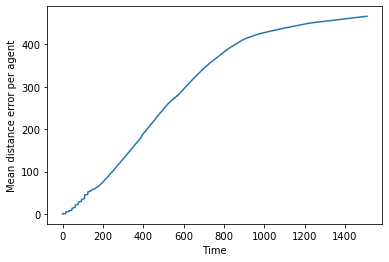

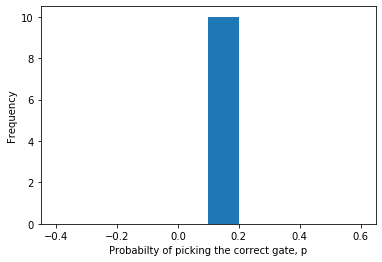

In [11]:
process_benchmark(model_dir + 'baseline_BY_AGENT.pkl', vis=False)

Run benchmark:

In [12]:
# Modeller.run_enkf_benchmark(ensemble_size=ensemble_size, pop_size=pop_size,
#                             exit_randomisation=ExitRandomisation.ALL_RANDOM)

### Analysis

#### Benchmark

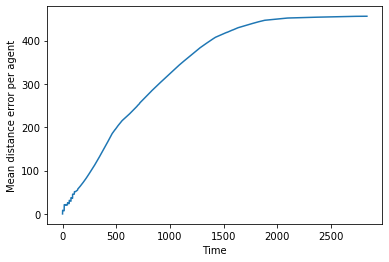

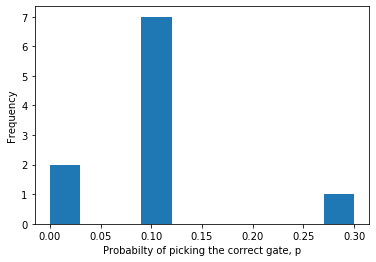

In [13]:
process_benchmark(model_dir + 'baseline_ALL_RANDOM.pkl', vis=False)

## Benchmarking filter without exit gate knowledge

Run benchmark:

In [14]:
# Modeller.run_enkf_benchmark_filter(ensemble_size=ensemble_size, pop_size=pop_size,
#                                    exit_randomisation=ExitRandomisation.BY_AGENT)

### Analysis

#### Benchmark

Agent 0
Agent 1
Agent 2
Agent 3
Agent 4
Agent 5
Agent 6
Agent 7
Agent 8
Agent 9


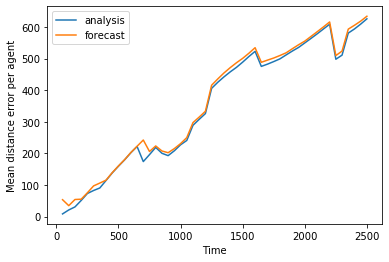

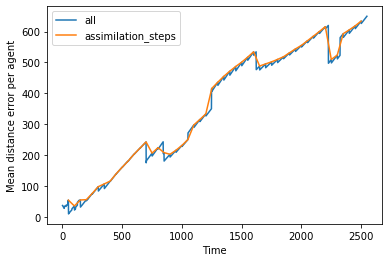

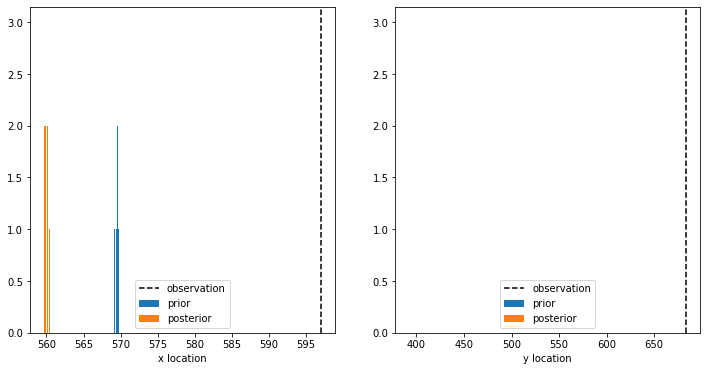

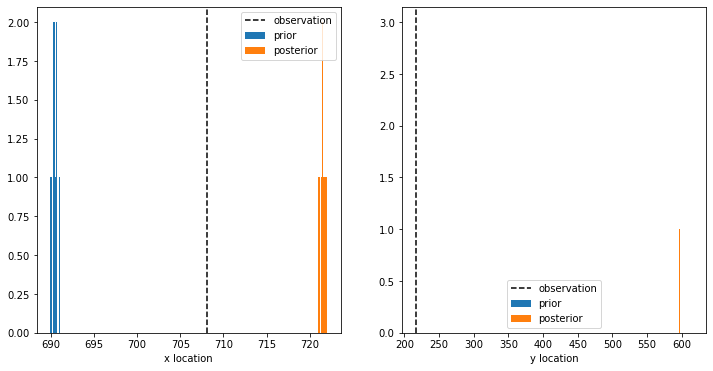

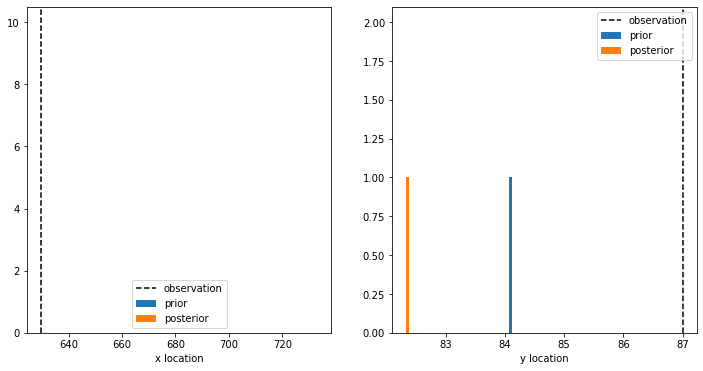

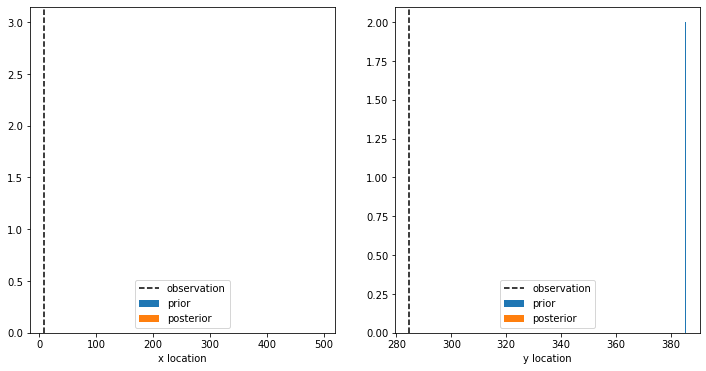

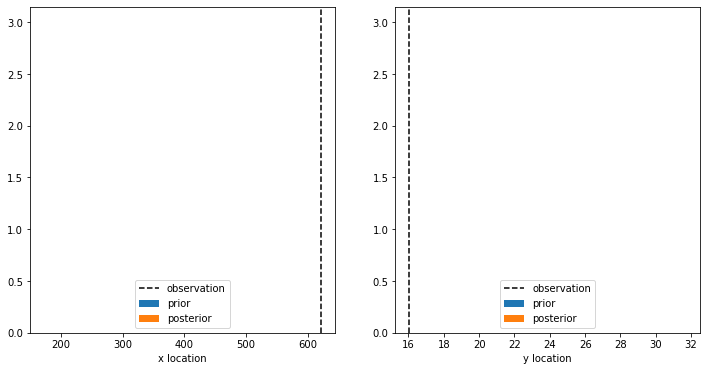

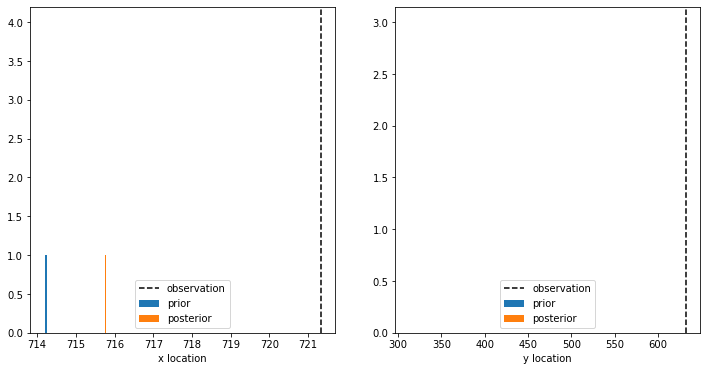

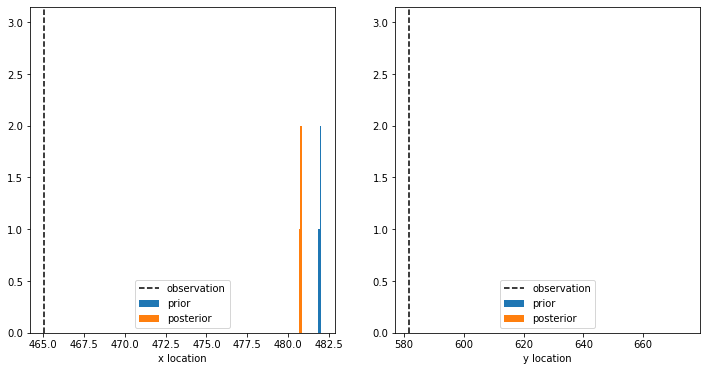

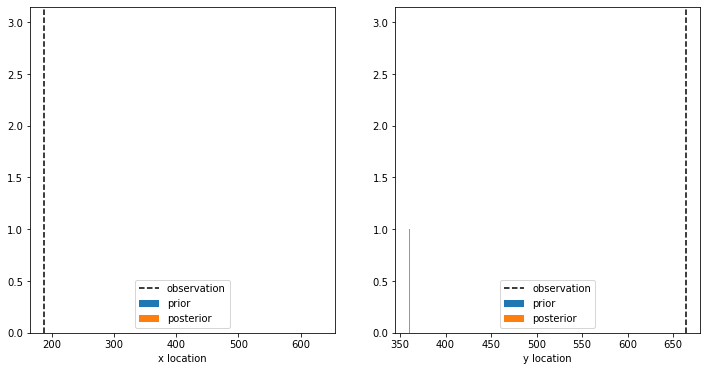

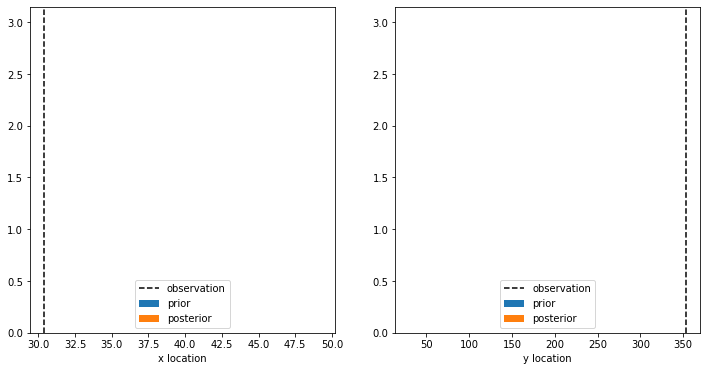

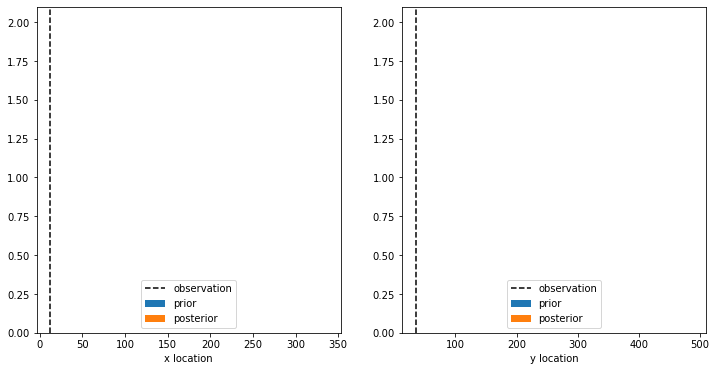

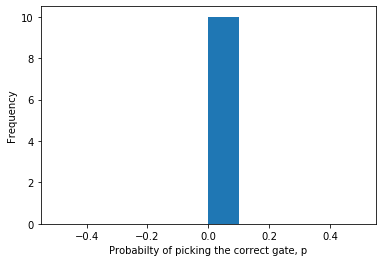

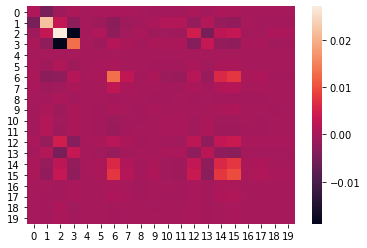

In [17]:
process_filter_benchmark(model_dir + 'baseline_filter_BY_AGENT.pkl', vis=False)

Run benchmark:

In [ ]:
# Modeller.run_enkf_benchmark_filter(ensemble_size=ensemble_size, pop_size=pop_size,
#                                    exit_randomisation=ExitRandomisation.ALL_RANDOM)

### Analysis

#### Benchmark

Agent 0
Agent 1
Agent 2
Agent 3
Agent 4
Agent 5
Agent 6
Agent 7
Agent 8
Agent 9


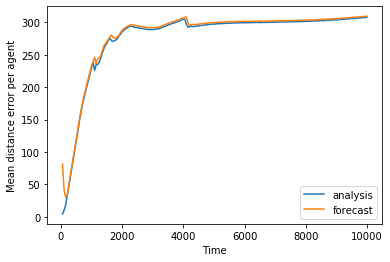

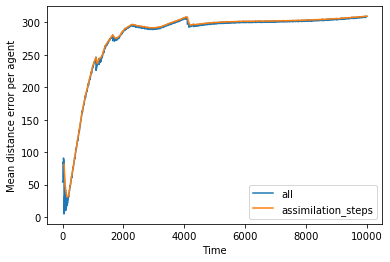

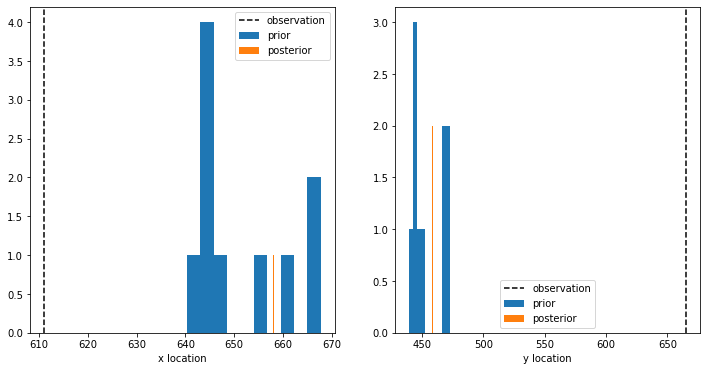

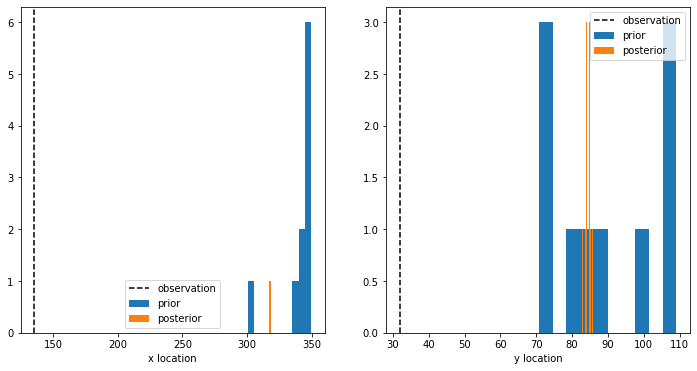

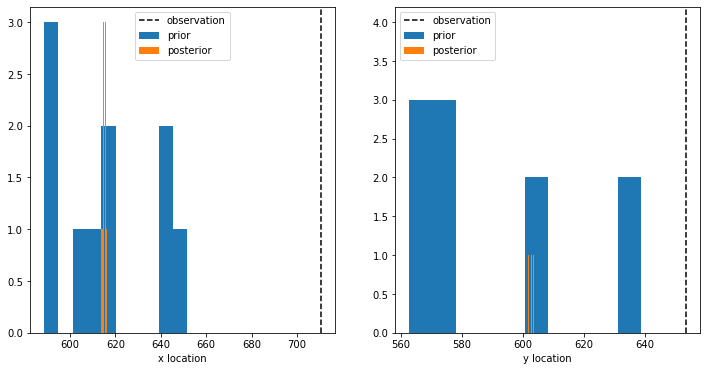

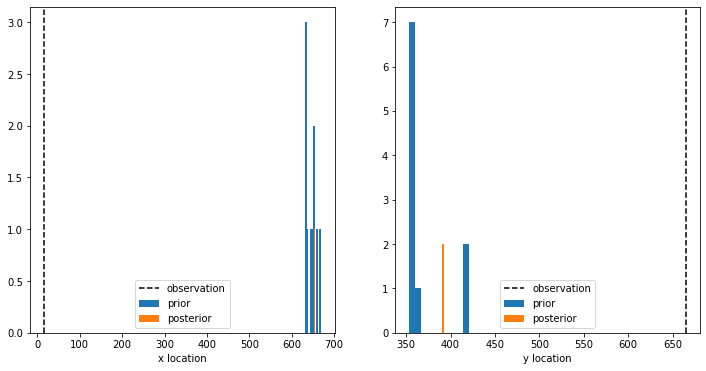

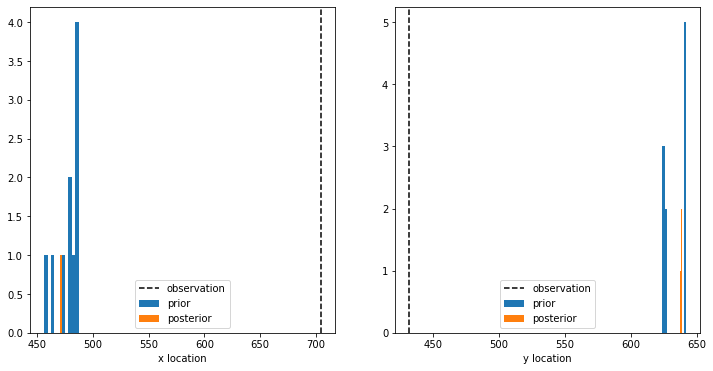

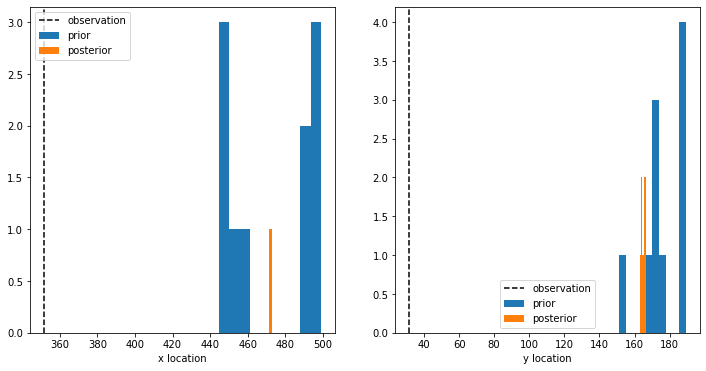

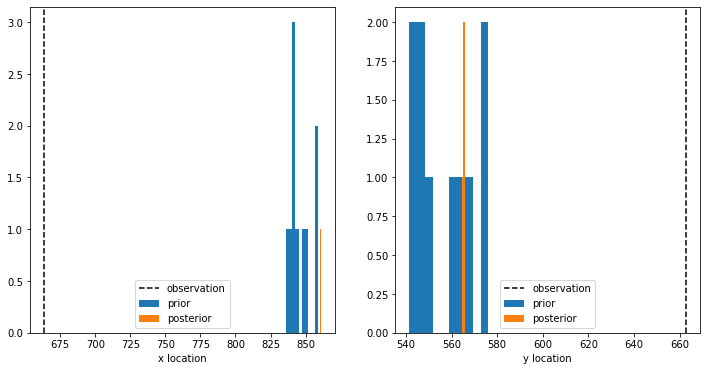

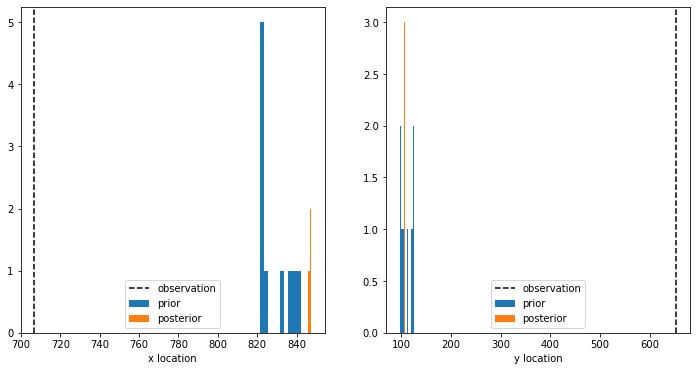

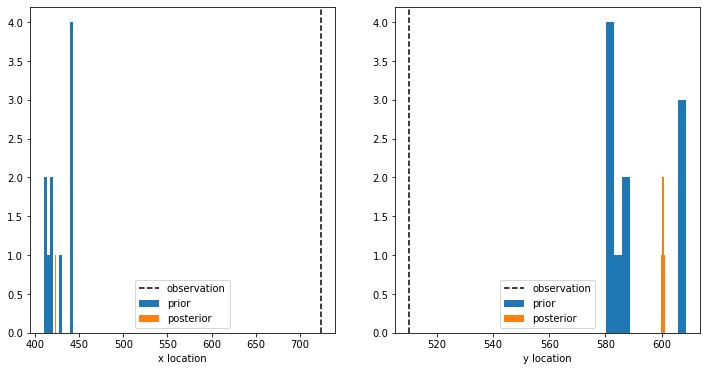

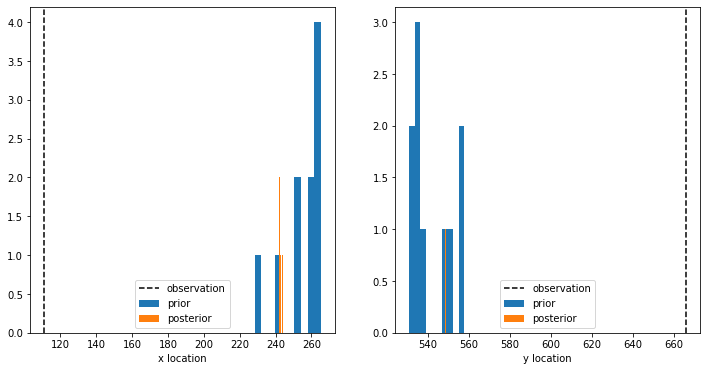

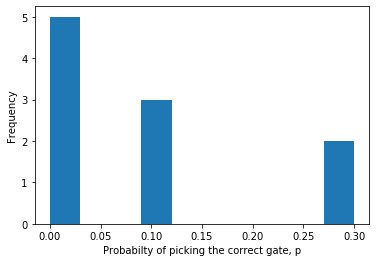

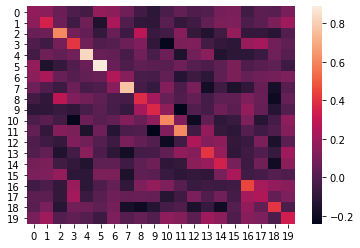

In [18]:
process_filter_benchmark(model_dir + 'baseline_filter_ALL_RANDOM.pkl', vis=False)